## Percobaan 5

Ekualisasi, Mean, Sobel, Threshold, dan Closing

In [84]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

## Data Loading

In [85]:
data = []
labels = []
file_name = []

for sub_folder in os.listdir("dataset\\"):
    sub_folder_files = os.listdir(os.path.join("dataset\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset\\", sub_folder, filename)
        img = cv.imread(img_path)
        if img is not None:
            # Ambil channel hijau dari gambar
            green = img[:, :, 1]
            green = cv.resize(green, (150, 150)) # Resize gambar yag diambil
            green = green.astype(np.uint8)

            # img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            # img = cv.resize(img, (150, 150))  # Resize ke ukuran tetap
            # img = img.astype(np.uint8)

            data.append(green)
            labels.append(sub_folder)
            name = os.path.splitext(filename)[0]
            file_name.append(filename)

data = np.array(data)
labels = np.array(labels)

## Data Preparation


### Define Preprocessing

In [86]:
def histogram_equalization(img_gray):
    hist, bins = np.histogram(img_gray.flatten(), bins=256, range=[0,255])
    cdf = hist.cumsum()
    cdf_normalized = cdf * 255 / cdf[-1]
    img_eq = np.interp(img_gray.flatten(), bins[:-1], cdf_normalized)
    return img_eq.reshape(img_gray.shape).astype(np.uint8)

def mean_filter(img, kernel_size=3):
    pad = kernel_size // 2
    padded = np.pad(img, pad, mode='constant', constant_values=0)
    result = np.zeros_like(img, dtype=np.float32)  # Gunakan float32 untuk akurasi

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            window = padded[i:i+kernel_size, j:j+kernel_size]
            total = np.sum(window)
            result[i, j] = total / (kernel_size * kernel_size)
    
    return np.clip(result, 0, 255).astype(np.uint8)  # Clip dan konversi ke uint8


def median_filter(img, kernel_size=3):
    pad_size = kernel_size // 2
    padded = np.pad(img, pad_size, mode='edge')
    filtered = np.zeros_like(img)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            # Ambil jendela lokal
            window = padded[i:i+kernel_size, j:j+kernel_size].flatten()
            # Hitung median
            median_val = np.median(window)
            filtered[i, j] = median_val

    return filtered.astype(np.uint8)

In [87]:
Sx = np.array([[-1,0,1],
               [-2,0,2],
               [-1,0,1]])

Sy = np.array([[1,2,1],
               [0,0,0],
               [-1,-2,-1]])

def sobel(img_gray):
   
    img_float = img_gray.astype(np.float32)

    rows, cols = img_float.shape

    Gx = np.zeros_like(img_float, dtype=np.float32)
    Gy = np.zeros_like(img_float, dtype=np.float32)

    kernel_size = 3
    pad_width = kernel_size // 2  

    padded_img = np.pad(img_float, pad_width, mode='symmetric')

    for i in range(rows):
        for j in range(cols):
            window = padded_img[i : i + kernel_size, j : j + kernel_size]

            Gx[i, j] = np.sum(window * Sx)
            Gy[i, j] = np.sum(window * Sy)

    G_magnitude = np.hypot(Gx, Gy)

    max_magnitude = np.max(G_magnitude)

    if max_magnitude > 0:
        G_normalized = (G_magnitude / max_magnitude) * 255.0
    else:
        G_normalized = G_magnitude 
        
    sobel_output = np.clip(G_normalized, 0, 255).astype(np.uint8)

    return sobel_output

# def threshold(gambar, threshold):
#     height, width = gambar.shape
#     mask = np.zeros_like(gambar)

#     for i in range(height):
#         for j in range(width):
#             if gambar[i, j] > threshold:
#                 mask[i, j] = 255
#             else:
#                 mask[i, j] = 0

#     return mask

In [88]:
# def dilasi(gambar, kernel):
#     gambar = gambar // 255
#     padded = np.pad(gambar, ((kernel.shape[0]//2, kernel.shape[0]//2), (kernel.shape[1]//2, kernel.shape[1]//2)), mode='constant', constant_values=0)
#     result = np.zeros_like(gambar)
#     k_h, k_w = kernel.shape

#     for i in range(gambar.shape[0]):
#         for j in range(gambar.shape[1]):
#             neighborhood = padded[i:i+k_h, j:j+k_w]
#             if np.any(neighborhood[kernel==1] == 1):
#                 result[i, j] = 1
#     return (result * 255).astype(np.uint8)

# def erosi(gambar, kernel):
#     gambar = gambar // 255
#     padded = np.pad(gambar, ((kernel.shape[0]//2, kernel.shape[0]//2), (kernel.shape[1]//2, kernel.shape[1]//2)), mode='constant', constant_values=0)
#     result = np.zeros_like(gambar)
#     k_h, k_w = kernel.shape

#     for i in range(gambar.shape[0]):
#         for j in range(gambar.shape[1]):
#             neighborhood = padded[i:i+k_h, j:j+k_w]
#             if np.all(neighborhood[kernel==1] == 1):
#                 result[i, j] = 1
#     return (result * 255).astype(np.uint8)

# def opening(gambar, kernel):
#     eroded = erosi(gambar, kernel)
#     opened = dilasi(eroded, kernel)
#     return opened.astype(np.uint8)

# def closing(gambar, kernel):
#     dilated = dilasi(gambar, kernel)
#     closed = erosi(dilated, kernel)
#     return closed.astype(np.uint8)


In [89]:
def gaussian_blur(img, kernel_size=5, sigma=1):
    # Membuat kernel Gaussian 2D
    kx = cv.getGaussianKernel(kernel_size, sigma)
    ky = cv.getGaussianKernel(kernel_size, sigma)
    kernel = np.outer(kx, ky)  # Membuat kernel 2D

    # Menambahkan padding pada gambar untuk menghindari batasan gambar
    padded = np.pad(img, kernel_size//2, mode='edge')
    blurred = np.zeros_like(img)
    
    # Melakukan konvolusi (filtering) antara gambar dan kernel
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = padded[i:i+kernel_size, j:j+kernel_size]
            blurred[i, j] = np.sum(region * kernel)  # Perkalian elemen per elemen dan penjumlahan
    
    return np.clip(blurred, 0, 255).astype(np.uint8)

def normalize(img):
    min_val = np.min(img)
    max_val = np.max(img)
    normalized = (img - min_val) * 255.0 / (max_val - min_val)
    return normalized.astype(np.uint8)

## Preprocessing

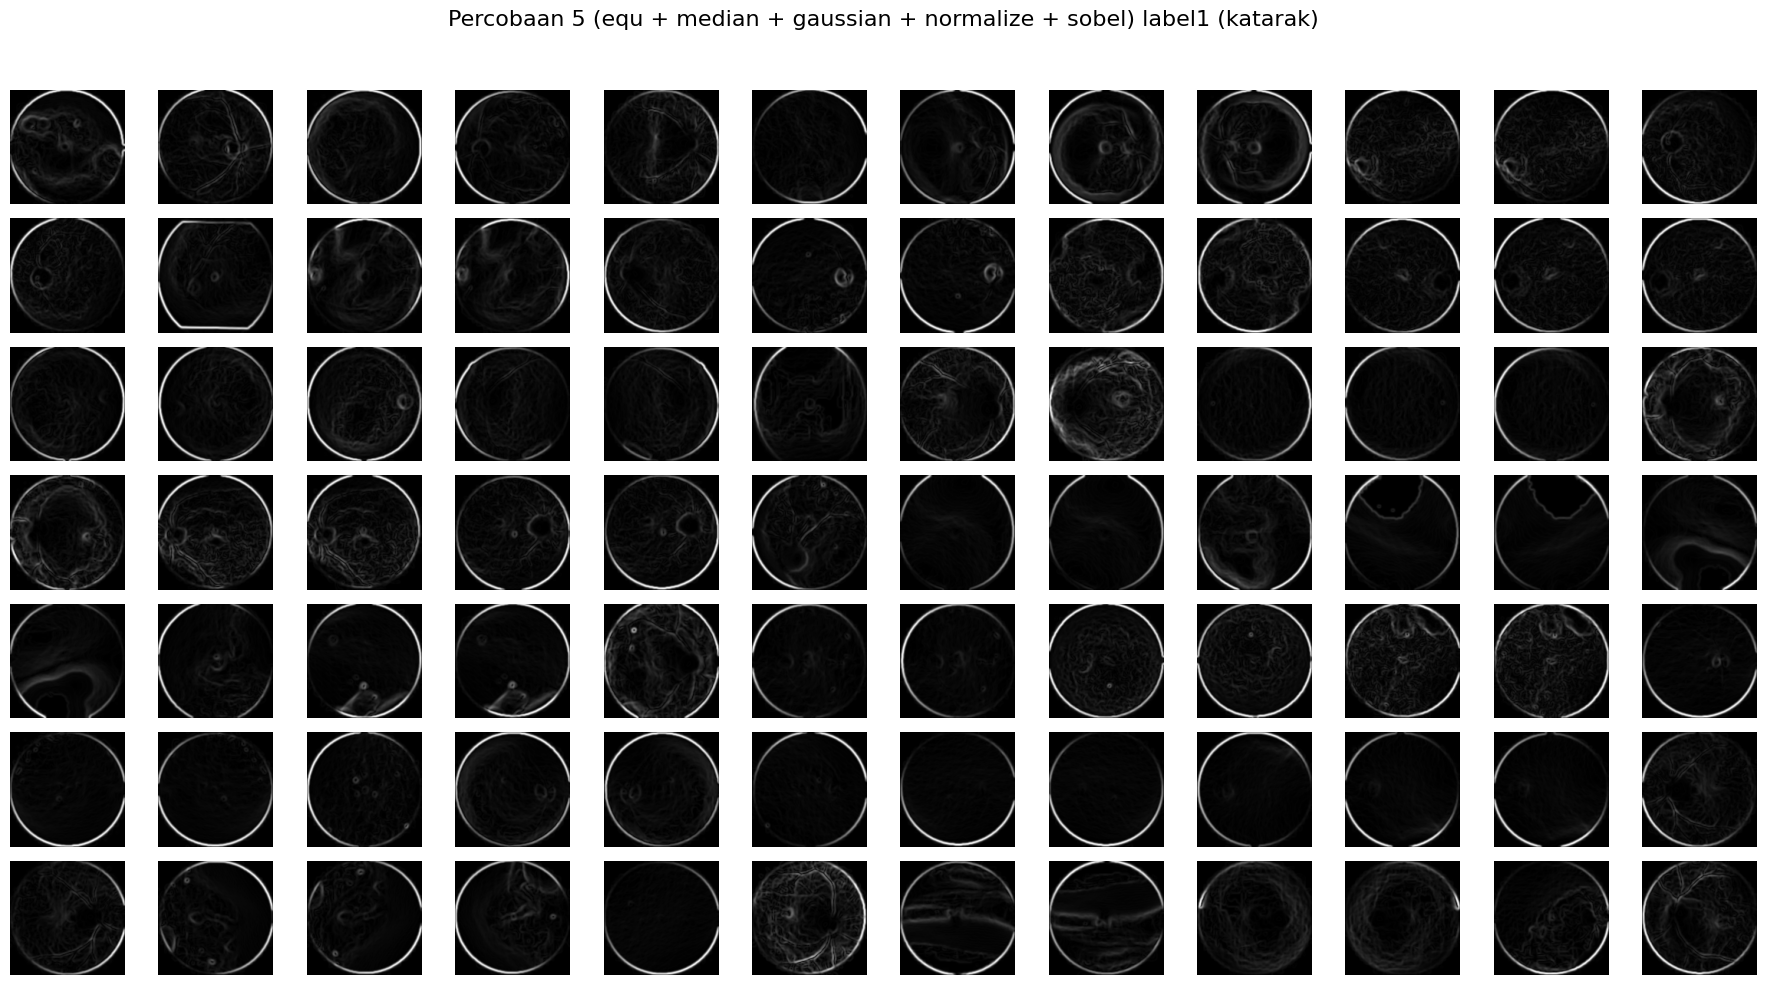

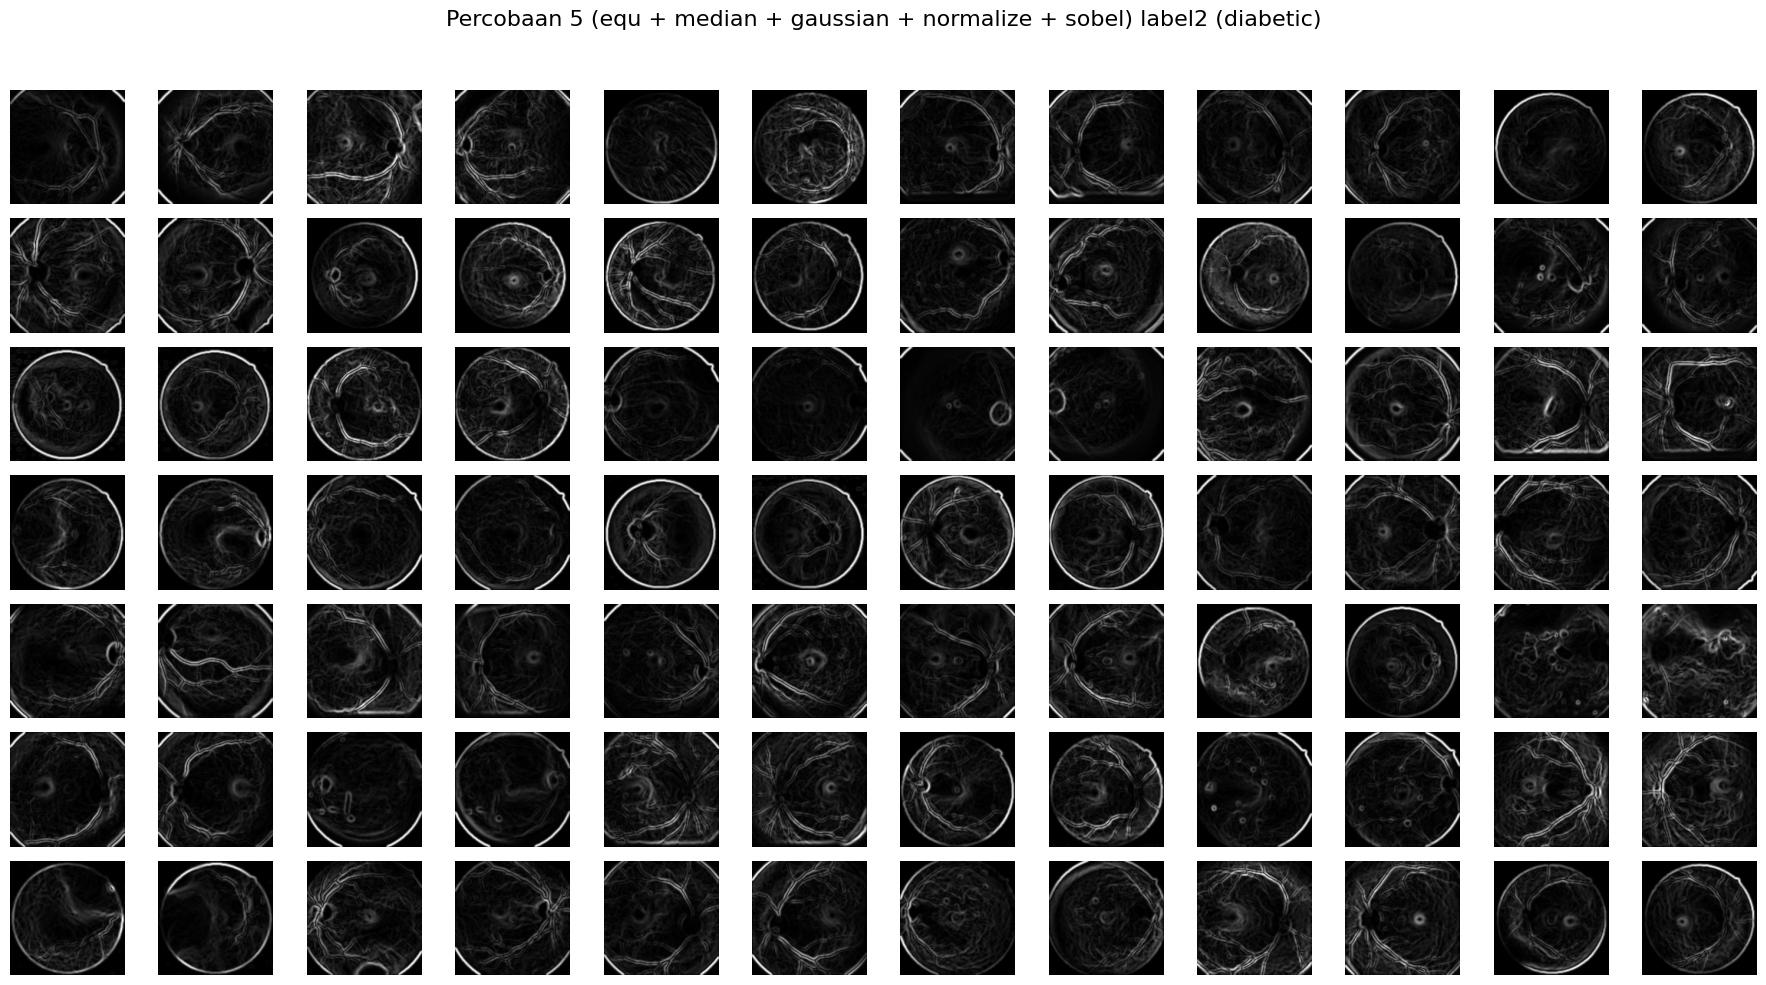

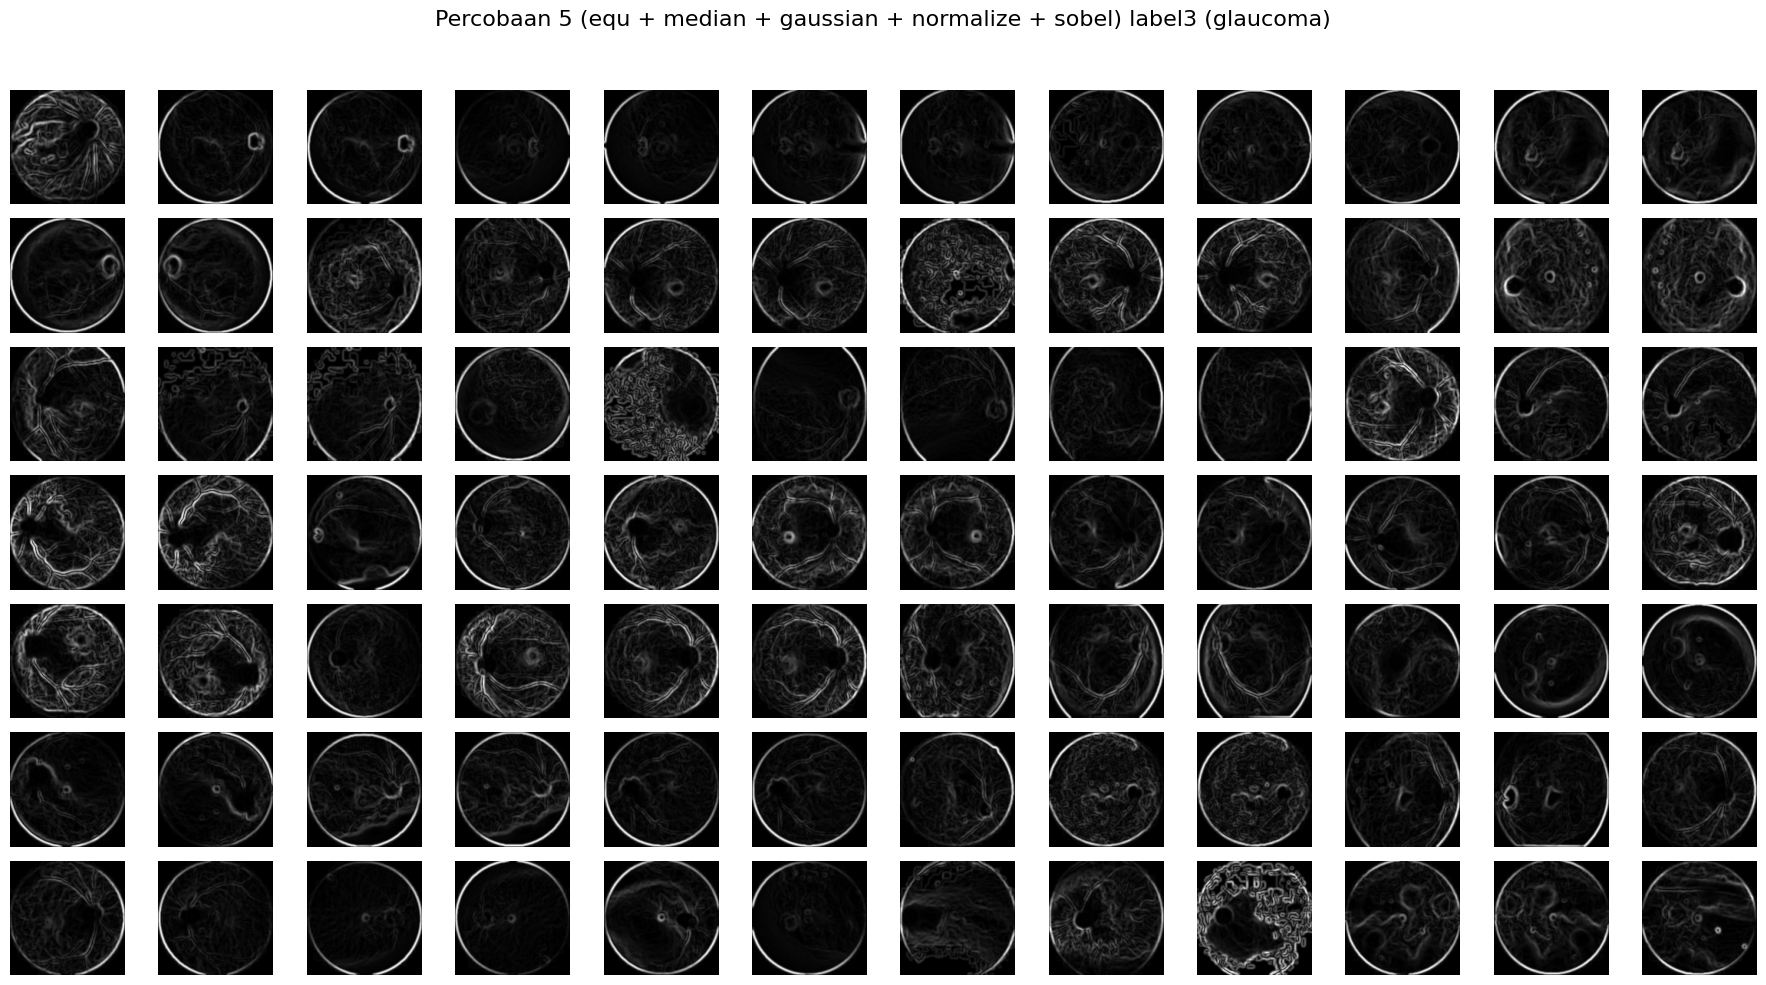

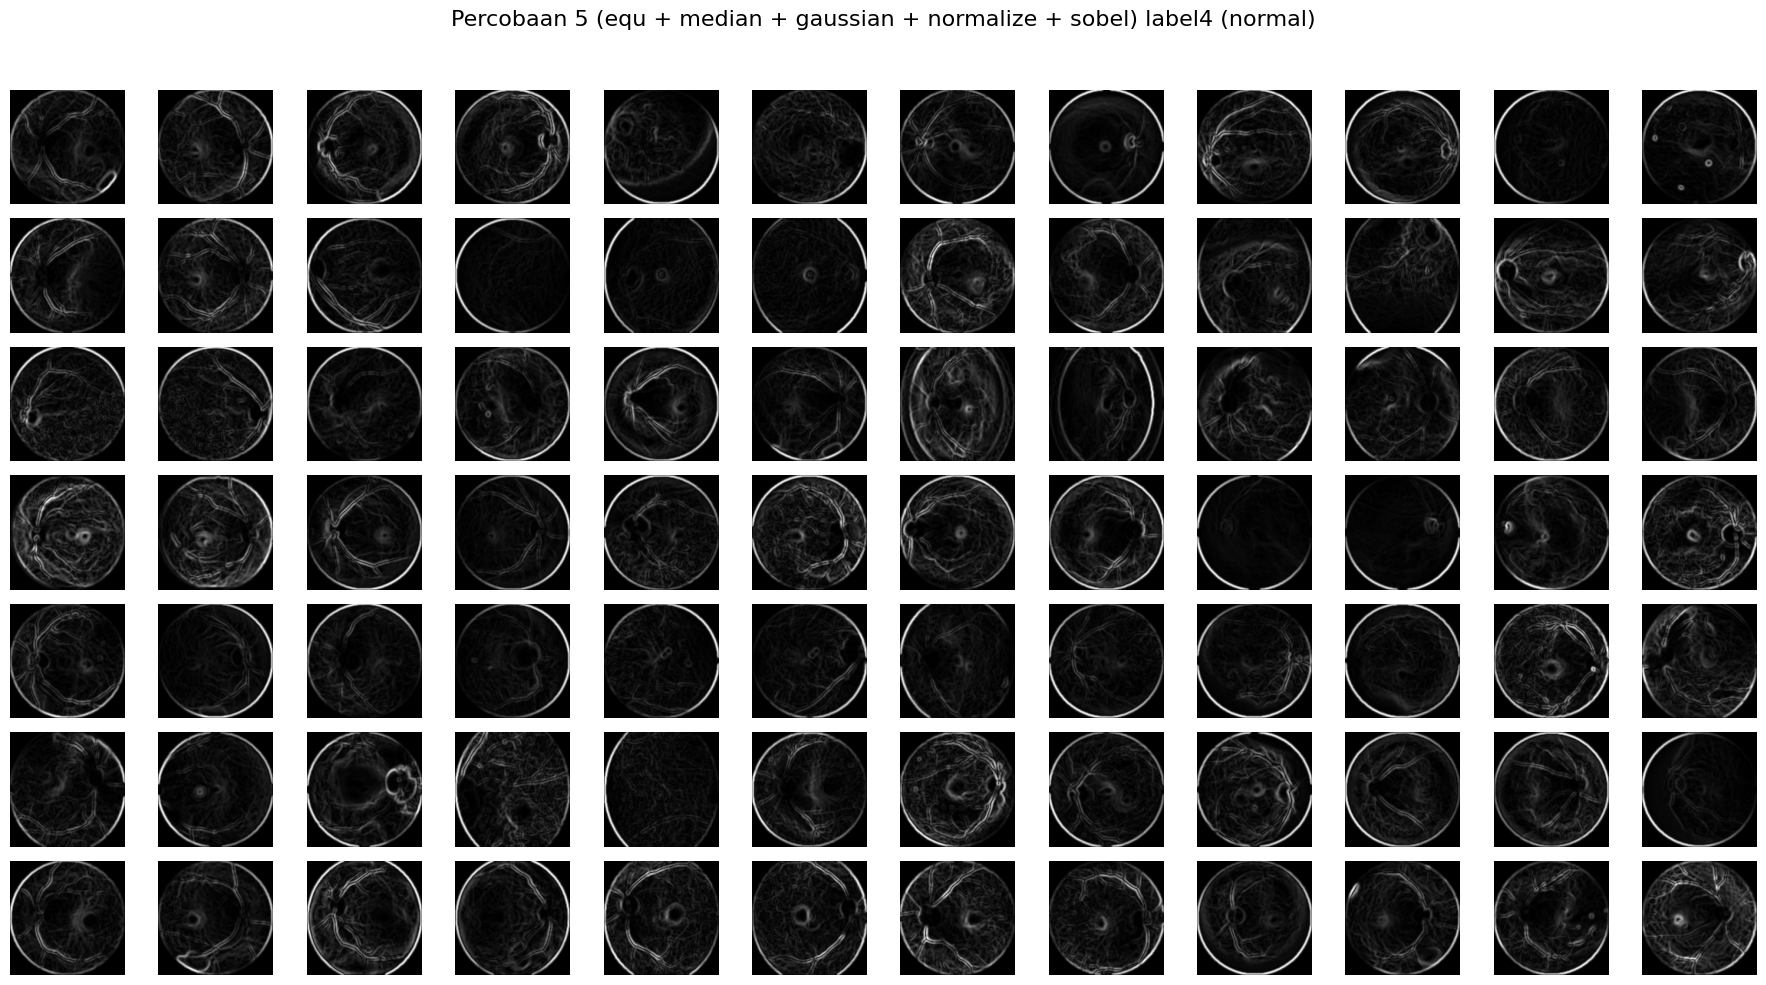

In [90]:
def percobaan5(green):
    img_eq = histogram_equalization(green)
    #img_mean = mean_filter(img_eq)
    #img_sob = sobel(img_mean)
    img_med = median_filter(img_eq)
    img_gau = gaussian_blur(img_med)
    img_nor = normalize(img_gau)
    img_sob = sobel(img_nor)
    #img_clos = closing(img_nor, np.ones((3, 3)))
    #img_open = opening(img_nor, np.ones((3, 3)))
    return img_sob

dataPreprocessed = [percobaan5(img) for img in data]  

unique_labels = sorted(set(labels))

for label in unique_labels:
    # Ambil semua indeks gambar dari label ini
    idxs = [j for j, l in enumerate(labels) if l == label]
    
    # Buat grid 7x12 (cukup untuk 84 gambar, 7*12 = 84)
    fig, axs = plt.subplots(7, 12, figsize=(18, 10))
    fig.suptitle(f'Percobaan 5 (equ + median + gaussian + normalize + sobel) {label}', fontsize=16)
    
    for k in range(84):
        row = k // 12
        col = k % 12
        ax = axs[row][col]
        ax.imshow(dataPreprocessed[idxs[k]], cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # beri ruang untuk judul
    plt.show()

## Ekstraksi Fitur

In [91]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    
    return glcm

In [92]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [ ]:
# Fungsi ekstraksi fitur untuk list citra
def ekstrak_fitur_glcm(data, nama_prepro):
    fitur_list = []
    for img in data:
        img_u8 = img.astype(np.uint8)
        m = glcm(img_u8, 0)  # derajat 0
        
        fitur = {
            'contrast': contrast(m),
            'correlation': correlation(m),
            'energy': energy(m),
            'homogeneity': homogenity(m),
            'dissimilarity': dissimilarity(m),
            'ASM': ASM(m),
            'entropy': entropyGlcm(m)
        }
        fitur_list.append(fitur)

    df = pd.DataFrame(fitur_list)
    df['tahap'] = nama_prepro
    return df

df5 = ekstrak_fitur_glcm(dataPreprocessed, 'percobaan5')
display(df5)

contrast  correlation    energy  homogeneity  dissimilarity       ASM  \
0    214.341566     0.909720  0.135361     0.430821       5.432125  0.018323   
1    185.404161     0.887834  0.136508     0.379949       5.592975  0.018634   
2    342.417763     0.894940  0.115228     0.409078       6.624385  0.013277   
3    190.950604     0.893152  0.148010     0.422379       4.747919  0.021907   
4    157.864698     0.882312  0.140724     0.365017       5.043490  0.019803   
..          ...          ...       ...          ...            ...       ...   
331  226.783848     0.879915  0.161493     0.308169       7.682640  0.026080   
332  370.797450     0.870411  0.165563     0.386892       7.742864  0.027411   
333  168.296957     0.876354  0.170909     0.352273       5.976779  0.029210   
334  207.862729     0.890170  0.169842     0.353626       6.850917  0.028846   
335  231.117808     0.891599  0.164664     0.286302       8.462237  0.027114   

      entropy       tahap  
0    6.118516  percobaan6  
1    6.071047  percobaan6  
2    6.058855  percobaan6  
3    5.685490  percobaan6  
4    6.134903  percobaan6  
..        ...         ...  
331  6.778460  percobaan6  
332  6.402422  percobaan6  
333  6.447824  percobaan6  
334  6.590932  percobaan6  
335  7.202048  percobaan6  

[336 rows x 8 columns]

In [94]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)



## Hasil Ekstraksi to CSV

In [95]:
features = []

for i in range(len(dataPreprocessed)):
    fitur = [
        contrast(Derajat0[i]), contrast(Derajat45[i]), contrast(Derajat90[i]), contrast(Derajat135[i]),
        dissimilarity(Derajat0[i]), dissimilarity(Derajat45[i]), dissimilarity(Derajat90[i]), dissimilarity(Derajat135[i]),
        homogenity(Derajat0[i]), homogenity(Derajat45[i]), homogenity(Derajat90[i]), homogenity(Derajat135[i]),
        entropyGlcm(Derajat0[i]), entropyGlcm(Derajat45[i]), entropyGlcm(Derajat90[i]), entropyGlcm(Derajat135[i]),
        ASM(Derajat0[i]), ASM(Derajat45[i]), ASM(Derajat90[i]), ASM(Derajat135[i]),
        energy(Derajat0[i]), energy(Derajat45[i]), energy(Derajat90[i]), energy(Derajat135[i]),
        correlation(Derajat0[i]), correlation(Derajat45[i]), correlation(Derajat90[i]), correlation(Derajat135[i]),
    ]
    features.append(fitur)

# Buat dataframe
columns = [
    "contrast_0", "contrast_45", "contrast_90", "contrast_135",
    "dissimilarity_0", "dissimilarity_45", "dissimilarity_90", "dissimilarity_135",
    "homogeneity_0", "homogeneity_45", "homogeneity_90", "homogeneity_135",
    "entropy_0", "entropy_45", "entropy_90", "entropy_135",
    "ASM_0", "ASM_45", "ASM_90", "ASM_135",
    "energy_0", "energy_45", "energy_90", "energy_135",
    "correlation_0", "correlation_45", "correlation_90", "correlation_135"
]

df_fitur = pd.DataFrame(features, columns=columns)


In [96]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_percobaan5.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_percobaan5.csv')
hasilEkstrak


Filename             Label   Contrast0  Contrast45  Contrast90  \
0     _0_4015166.jpg  label1 (katarak)  214.341566  357.277330  245.206085   
1    _10_3215668.jpg  label1 (katarak)  185.404161  268.698797  164.859195   
2    _11_7158929.jpg  label1 (katarak)  342.417763  609.558488  317.201745   
3    _12_5233869.jpg  label1 (katarak)  190.950604  321.301248  163.658926   
4    _13_3987009.jpg  label1 (katarak)  157.864698  268.606684   99.332841   
..               ...               ...         ...         ...         ...   
331      8_right.jpg   label4 (normal)  226.783848  427.151435  231.271678   
332     939_left.jpg   label4 (normal)  370.797450  596.875006  293.341342   
333    939_right.jpg   label4 (normal)  168.296957  316.043827  126.067830   
334     951_left.jpg   label4 (normal)  207.862729  471.258547  237.866174   
335    951_right.jpg   label4 (normal)  231.117808  475.016711  251.962550   

     Contrast135  Homogeneity0  Homogeneity45  Homogeneity90  Homogeneity135  \
0     492.706094      0.430821       0.362021       0.394142        0.343028   
1     371.744606      0.379949       0.327162       0.365723        0.313961   
2     615.480834      0.409078       0.361891       0.438834        0.364122   
3     335.378992      0.422379       0.375182       0.432163        0.365587   
4     210.983604      0.365017       0.327903       0.398372        0.332039   
..           ...           ...            ...            ...             ...   
331   366.983514      0.308169       0.268573       0.307437        0.275230   
332   635.217603      0.386892       0.335983       0.381389        0.339186   
333   207.598892      0.352273       0.316728       0.353664        0.310183   
334   322.732805      0.353626       0.311187       0.351335        0.316994   
335   359.477141      0.286302       0.257898       0.282323        0.258085   

     ...     ASM90    ASM135   Energy0  Energy45  Energy90  Energy135  \
0    ...  0.017968  0.016238  0.135361  0.128485  0.134046   0.127427   
1    ...  0.018307  0.016672  0.136508  0.129587  0.135304   0.129122   
2    ...  0.013836  0.011757  0.115228  0.108043  0.117625   0.108429   
3    ...  0.022055  0.019812  0.148010  0.140928  0.148509   0.140757   
4    ...  0.020103  0.018116  0.140724  0.134107  0.141784   0.134594   
..   ...       ...       ...       ...       ...       ...        ...   
331  ...  0.025994  0.024314  0.161493  0.155704  0.161226   0.155930   
332  ...  0.027293  0.025537  0.165563  0.159670  0.165205   0.159802   
333  ...  0.029282  0.027219  0.170909  0.164875  0.171119   0.164983   
334  ...  0.028905  0.026947  0.169842  0.163473  0.170014   0.164154   
335  ...  0.027075  0.025406  0.164664  0.159420  0.164545   0.159392   

     Correlation0  Correlation45  Correlation90  Correlation135  
0        0.909720       0.849393       0.896442        0.792304  
1        0.887834       0.837197       0.899915        0.774762  
2        0.894940       0.813304       0.902583        0.811491  
3        0.893152       0.820919       0.909008        0.813073  
4        0.882312       0.800469       0.926587        0.843274  
..            ...            ...            ...             ...  
331      0.879915       0.774016       0.877550        0.805848  
332      0.870411       0.791029       0.897756        0.777605  
333      0.876354       0.768560       0.907808        0.847975  
334      0.890170       0.750531       0.873822        0.829156  
335      0.891599       0.777477       0.881853        0.831602  

[336 rows x 30 columns]

## Feature Selection

### Correlation

<Axes: >

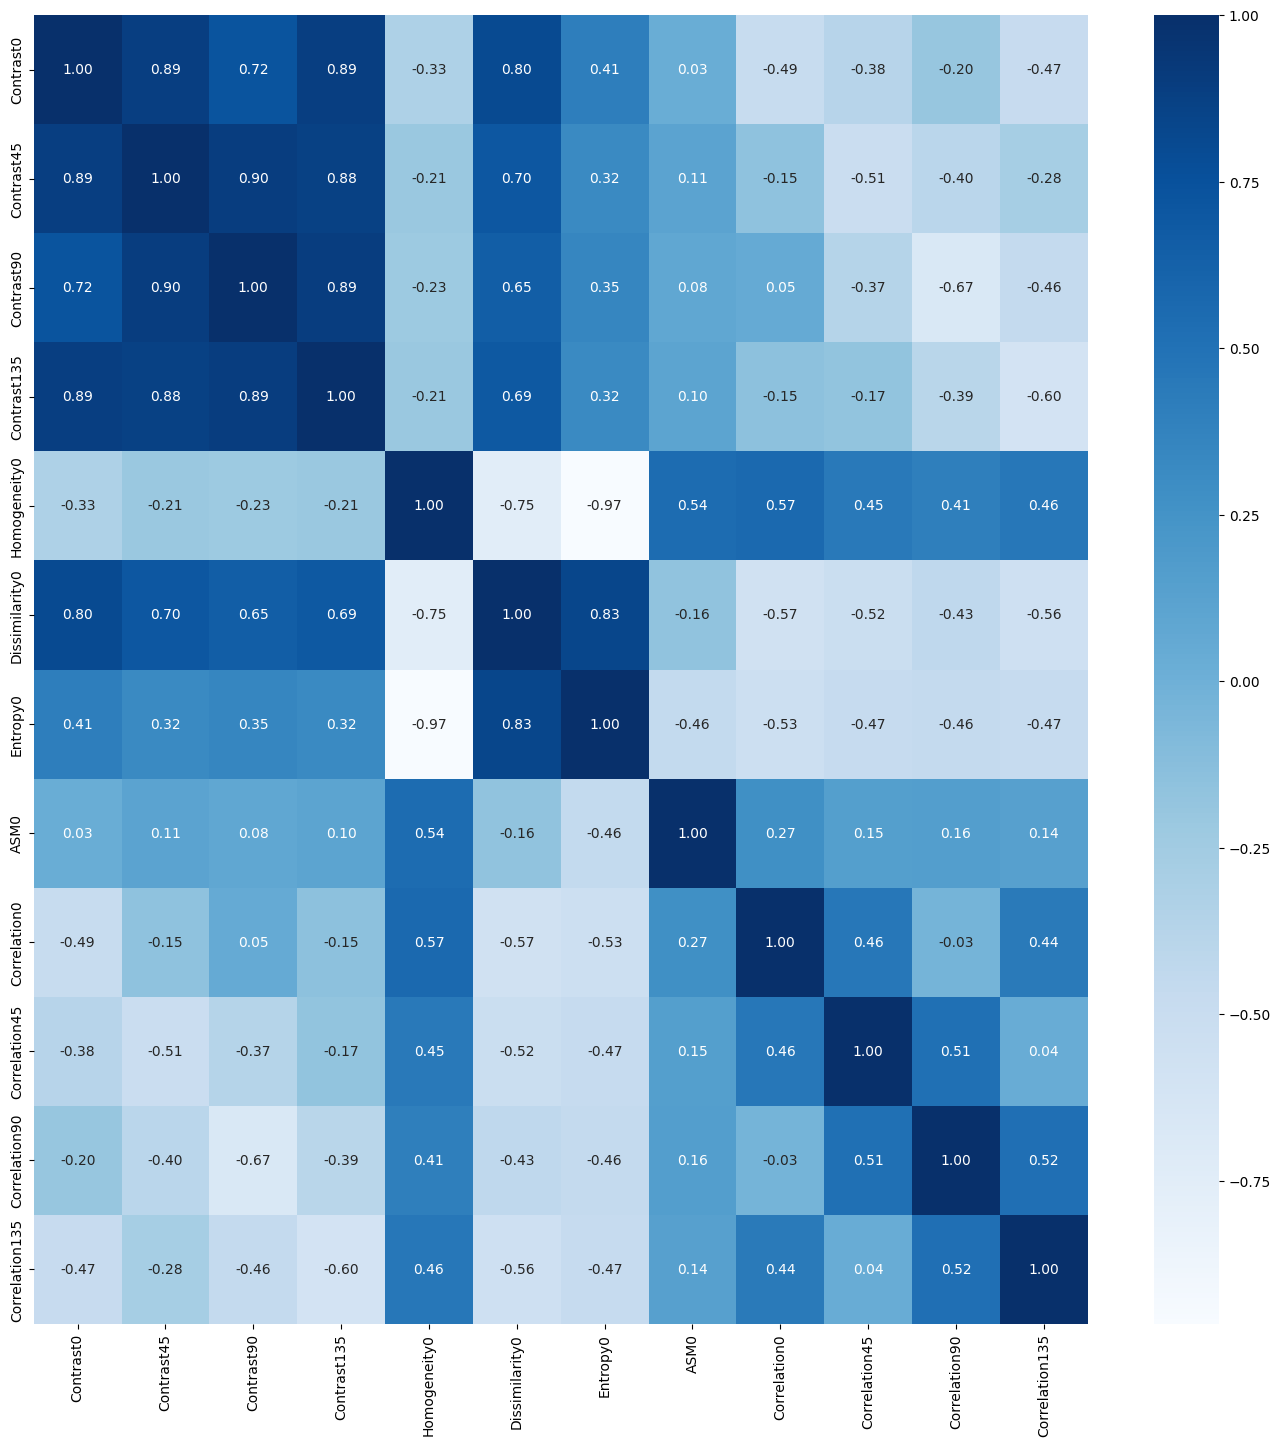

In [97]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

### LDA

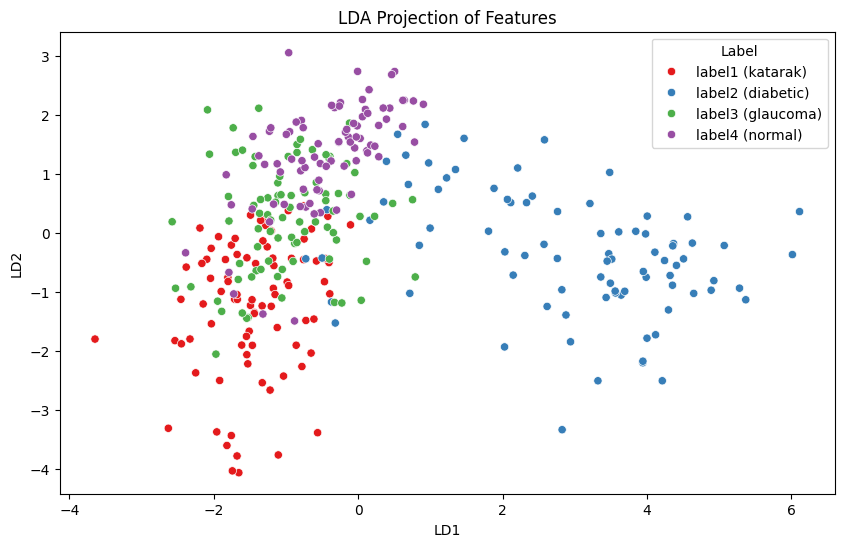

In [98]:
# Selection LDA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def feature_reduction_lda(dataframe, n_components=2):
    fitur = dataframe.drop(columns=['Label', 'Filename'])
    label = dataframe['Label']
    
    lda = LinearDiscriminantAnalysis(n_components=n_components)
    x_lda = lda.fit_transform(fitur, label)
    
    columns = [f'LD{i+1}' for i in range(n_components)]
    df_lda = pd.DataFrame(x_lda, columns=columns)
    df_lda['Label'] = label.values
    
    return df_lda

lda_df = feature_reduction_lda(hasilEkstrak, n_components=2)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=lda_df, x='LD1', y='LD2', hue='Label', palette='Set1')
plt.title('LDA Projection of Features')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(title='Label')
plt.show()

### t-SNE

c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


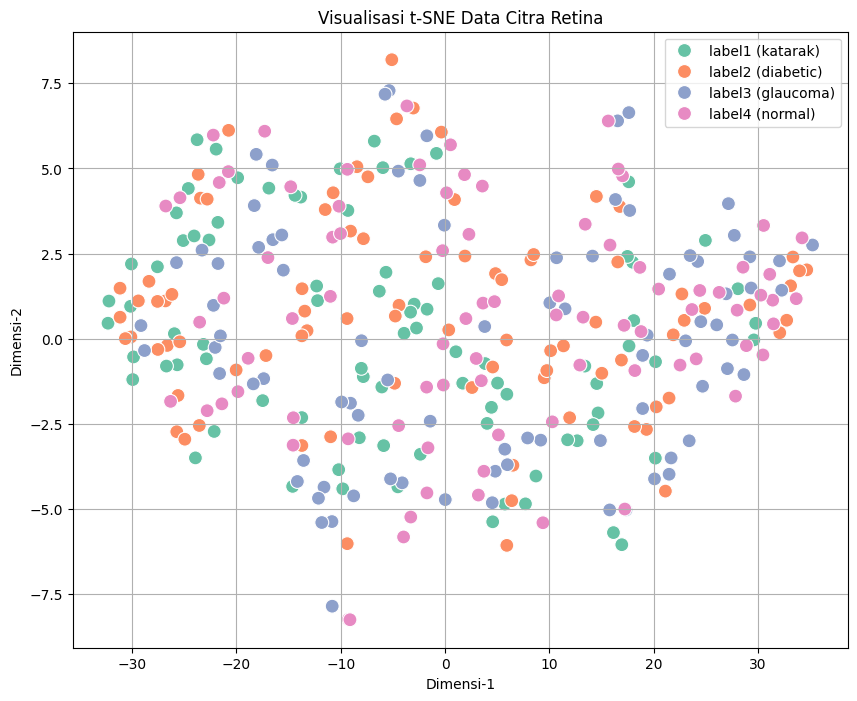

In [99]:
# Selection t-SNE

from sklearn.manifold import TSNE

# Jalankan t-SNE untuk reduksi ke 2 dimensi
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(x_new)

# Buat DataFrame hasil t-SNE
df_tsne = pd.DataFrame()
df_tsne['Dimensi-1'] = X_tsne[:, 0]
df_tsne['Dimensi-2'] = X_tsne[:, 1]
df_tsne['Label'] = y

# Plot dengan seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Dimensi-1', y='Dimensi-2', hue='Label', data=df_tsne, palette='Set2', s=100
)
plt.title('Visualisasi t-SNE Data Citra Retina')
plt.legend(loc='best')
plt.grid(True)
plt.show()


## Splitting Data

In [100]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(268, 12)
(68, 12)
(268,)
(68,)


## Feature Normalization

In [101]:
# normalisasi mean std (Standardization / Z-score normalization)
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

### Define Model

In [102]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [103]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
                   precision    recall  f1-score   support

 label1 (katarak)       1.00      0.97      0.98        64
label2 (diabetic)       0.94      1.00      0.97        67
label3 (glaucoma)       0.95      0.97      0.96        72
  label4 (normal)       1.00      0.94      0.97        65

         accuracy                           0.97       268
        macro avg       0.97      0.97      0.97       268
     weighted avg       0.97      0.97      0.97       268

[[62  0  2  0]
 [ 0 67  0  0]
 [ 0  2 70  0]
 [ 0  2  2 61]]
Accuracy: 0.9701492537313433

------Testing Set------
                   precision    recall  f1-score   support

 label1 (katarak)       0.79      0.55      0.65        20
label2 (diabetic)       0.69      0.65      0.67        17
label3 (glaucoma)       0.42      0.83      0.56        12
  label4 (normal)       0.71      0.53      0.61        19

         accuracy                           0.62        68
        macro avg       0.65 

### Train SVM Classifier

In [104]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
                   precision    recall  f1-score   support

 label1 (katarak)       0.74      0.78      0.76        64
label2 (diabetic)       1.00      0.72      0.83        67
label3 (glaucoma)       0.67      0.88      0.76        72
  label4 (normal)       0.88      0.78      0.83        65

         accuracy                           0.79       268
        macro avg       0.82      0.79      0.80       268
     weighted avg       0.82      0.79      0.79       268

[[50  0 14  0]
 [ 6 48  6  7]
 [ 9  0 63  0]
 [ 3  0 11 51]]
Accuracy: 0.7910447761194029

------Testing Set------
                   precision    recall  f1-score   support

 label1 (katarak)       0.76      0.65      0.70        20
label2 (diabetic)       0.73      0.65      0.69        17
label3 (glaucoma)       0.36      0.75      0.49        12
  label4 (normal)       0.82      0.47      0.60        19

         accuracy                           0.62        68
        macro avg       0.67

### Train KKN Classifier

In [105]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
                   precision    recall  f1-score   support

 label1 (katarak)       0.68      0.81      0.74        64
label2 (diabetic)       0.88      0.76      0.82        67
label3 (glaucoma)       0.65      0.74      0.69        72
  label4 (normal)       0.81      0.65      0.72        65

         accuracy                           0.74       268
        macro avg       0.75      0.74      0.74       268
     weighted avg       0.75      0.74      0.74       268

[[52  2 10  0]
 [ 4 51  5  7]
 [14  2 53  3]
 [ 6  3 14 42]]
Accuracy: 0.7388059701492538

------Testing Set------
                   precision    recall  f1-score   support

 label1 (katarak)       0.76      0.80      0.78        20
label2 (diabetic)       0.81      0.76      0.79        17
label3 (glaucoma)       0.47      0.75      0.58        12
  label4 (normal)       0.67      0.42      0.52        19

         accuracy                           0.68        68
        macro avg       0.68

## Evaluasi Dengan Confussion Matrix

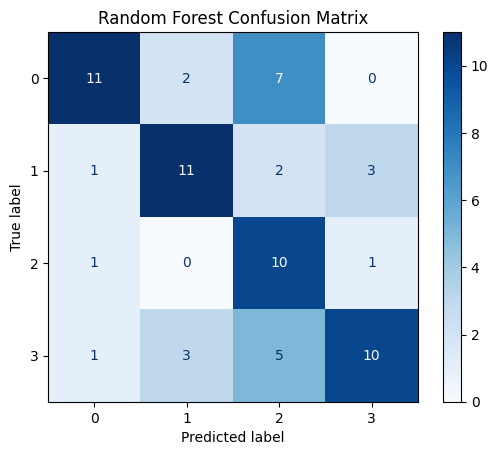

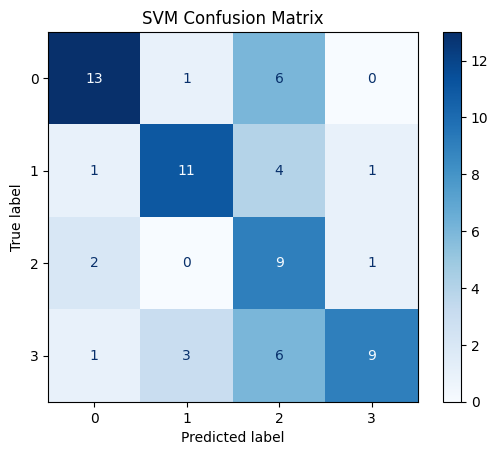

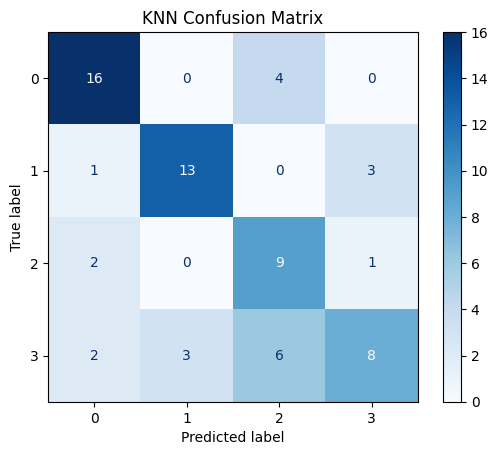

In [106]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")